# 3DeeCellTracker Demo: Single mode | Use StarDist

This notebook shows how to use 3DeeCellTracker to track cells in single mode. The segmentation is basded on the trained StarDist.

The demo data and pre-trained deep neural network models can be found in the "worm1", "stardist_models" and "ffn_models" folders  downloaded from https://osf.io/pgr95/

**The basic procedures:**
- A. Import packages
- B. Segment cells by StarDist3D
- C. Load manually corrected segmentation (t=1)
- D. Track cells by FFN + PRGLS + Fine-tune.
- E. Extract activities from the tracked cells.

## A. Import packages

In [10]:
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
import numpy as np
import tifffile as tiff

import CellTracker.trackerlite as trl
import CellTracker.stardistwrapper as sdw
import CellTracker.coord_image_transformer as cit
from CellTracker.analyses import draw_signals

## B. Segment cells by StarDist3D
### Load trained StarDist3D model

### Parameters
- `model_name`: A string specifying the name of the model to reload.

### Notes:
> By default, the function looks for the model with the specified name from the stardist_models directory. However, if you have saved the model in a different location, you can specify the `basedir` parameter to load the model from that directory.
```
    model = sdw.load_stardist_model(model_name=stardist_model_name, basedir=".\FolderA\FolderB\")
```

In [11]:
stardist_model_name = "C20230510_cam2_001_ch1"

model = sdw.load_stardist_model(model_name=stardist_model_name)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.728479, nms_thresh=0.3.
Load pretrained stardist model 'C20230510_cam2_001_ch1' from folder 'stardist_models'


### Segment the volume #1 image and save the segmentation in auto_vol1 folder

### Parameters
- `path_results`: A string specifying a directory to save the segmentation/tracking results.
- `path_raw_images`: A string specifying the file path to the raw images. The raw images could be a TIFF image sequence, or an HDF5 file with the data stored in "raw_images" key.

### Notes
> All of the time-lapse 3D images should be stored in a single directory. Each 3D image at time t should be saved as a sequence of 2D slices in TIFF format. The filename of each 2D image should contain the timing and slice number, such as "xxx_txxx_z_xxx.tif". To ensure that the program correctly loads the images for each timing, users should specify the format of the timing in the filename in the `path_raw_images` parameter. For example, "t%03d.tif" indicates that the filename should contain the letter "t" followed by a 3-digit number representing the timing, followed by any number of characters, and ending with the extension ".tif".

Raw image shape at vol1: (21, 512, 512)
1/1 [==============================] - 2s 2s/step


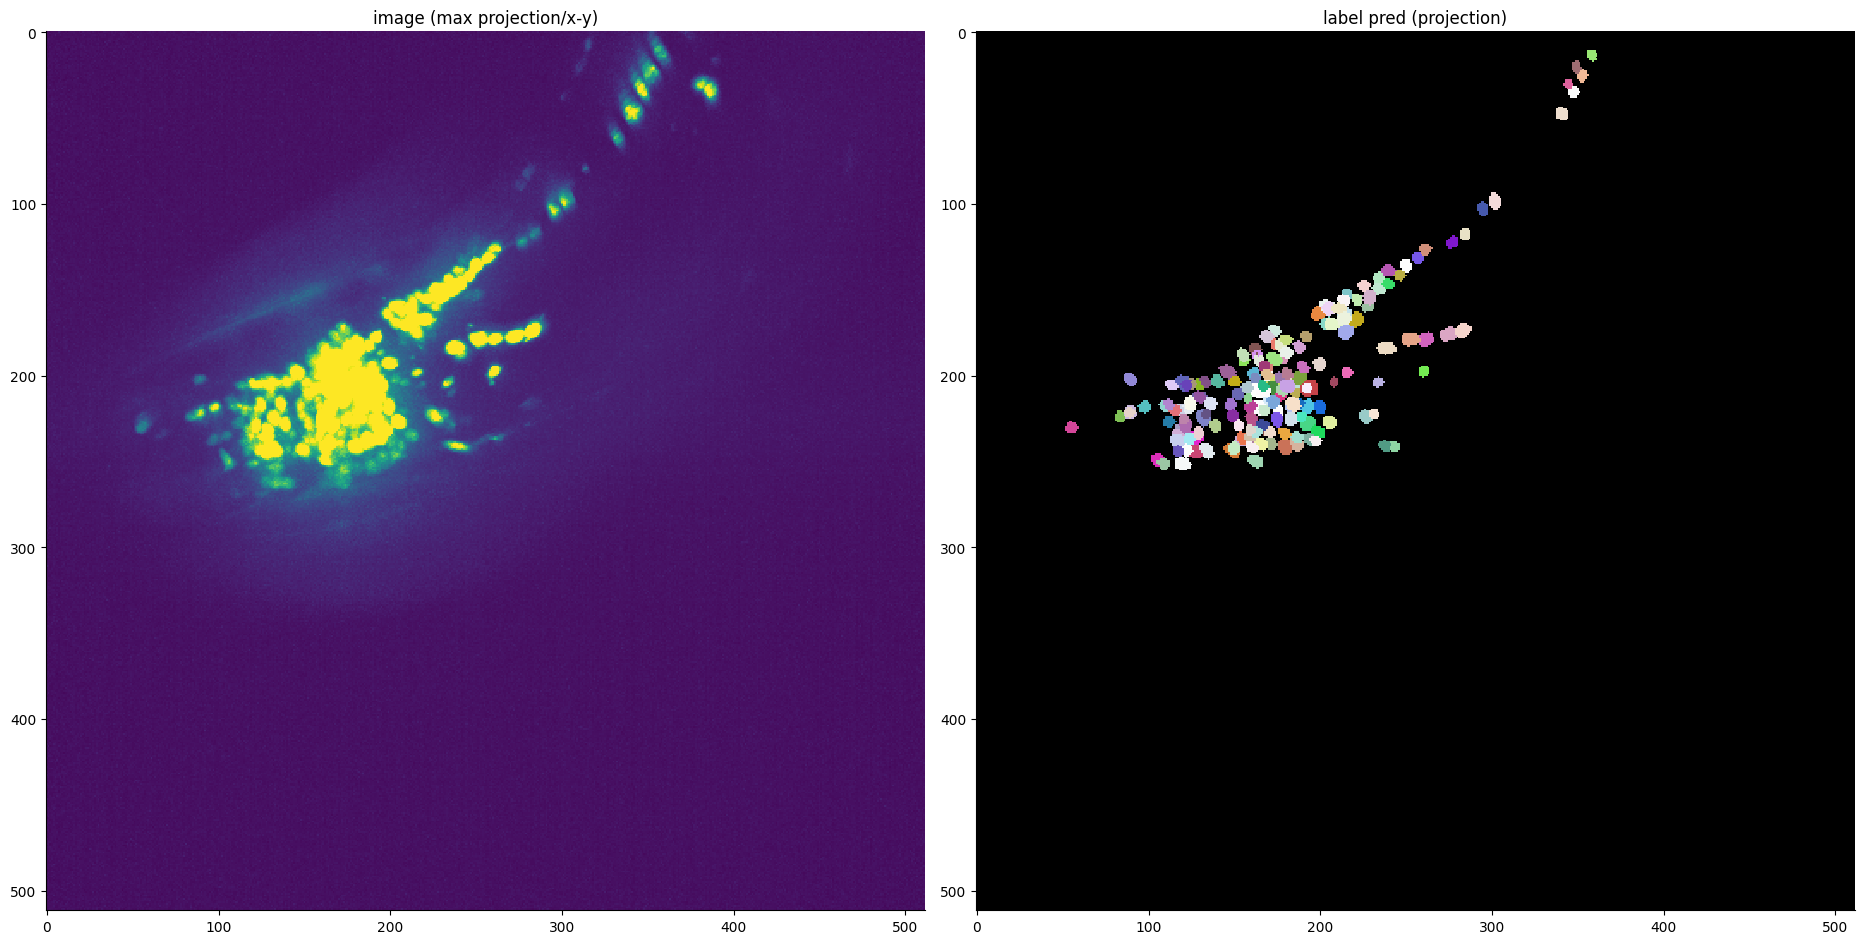

In [3]:
path_results = "E:\Mukumoto_taking_over\3DeeCellTracker\Examples\use_stardist\tracking_result\20230510_cam2_001_ch1\raw_t=17"
path_raw_images = "D:/c.elegans/fluorescence_image/Dr.Toyoshima/20230510_cam2_001_ch1/raw/*t%04d*.tif"

vol = 17
x = sdw.load_2d_slices_at_time(path_raw_images, t=vol)

print(f"Raw image shape at vol1: {x.shape}")

(labels, details), prob_map = model.predict_instances(x)
use_8_bit = True if labels.max() <= 255 else False

sdw.plot_img_label_max_projection(x, labels, lbl_title="label pred (projection)", fig_width_px=1800)

# Save result of cell detection as Tiff format


Raw image shape at vol1: (21, 512, 512)
1/1 [==============================] - 0s 30ms/step
(21, 512, 512)


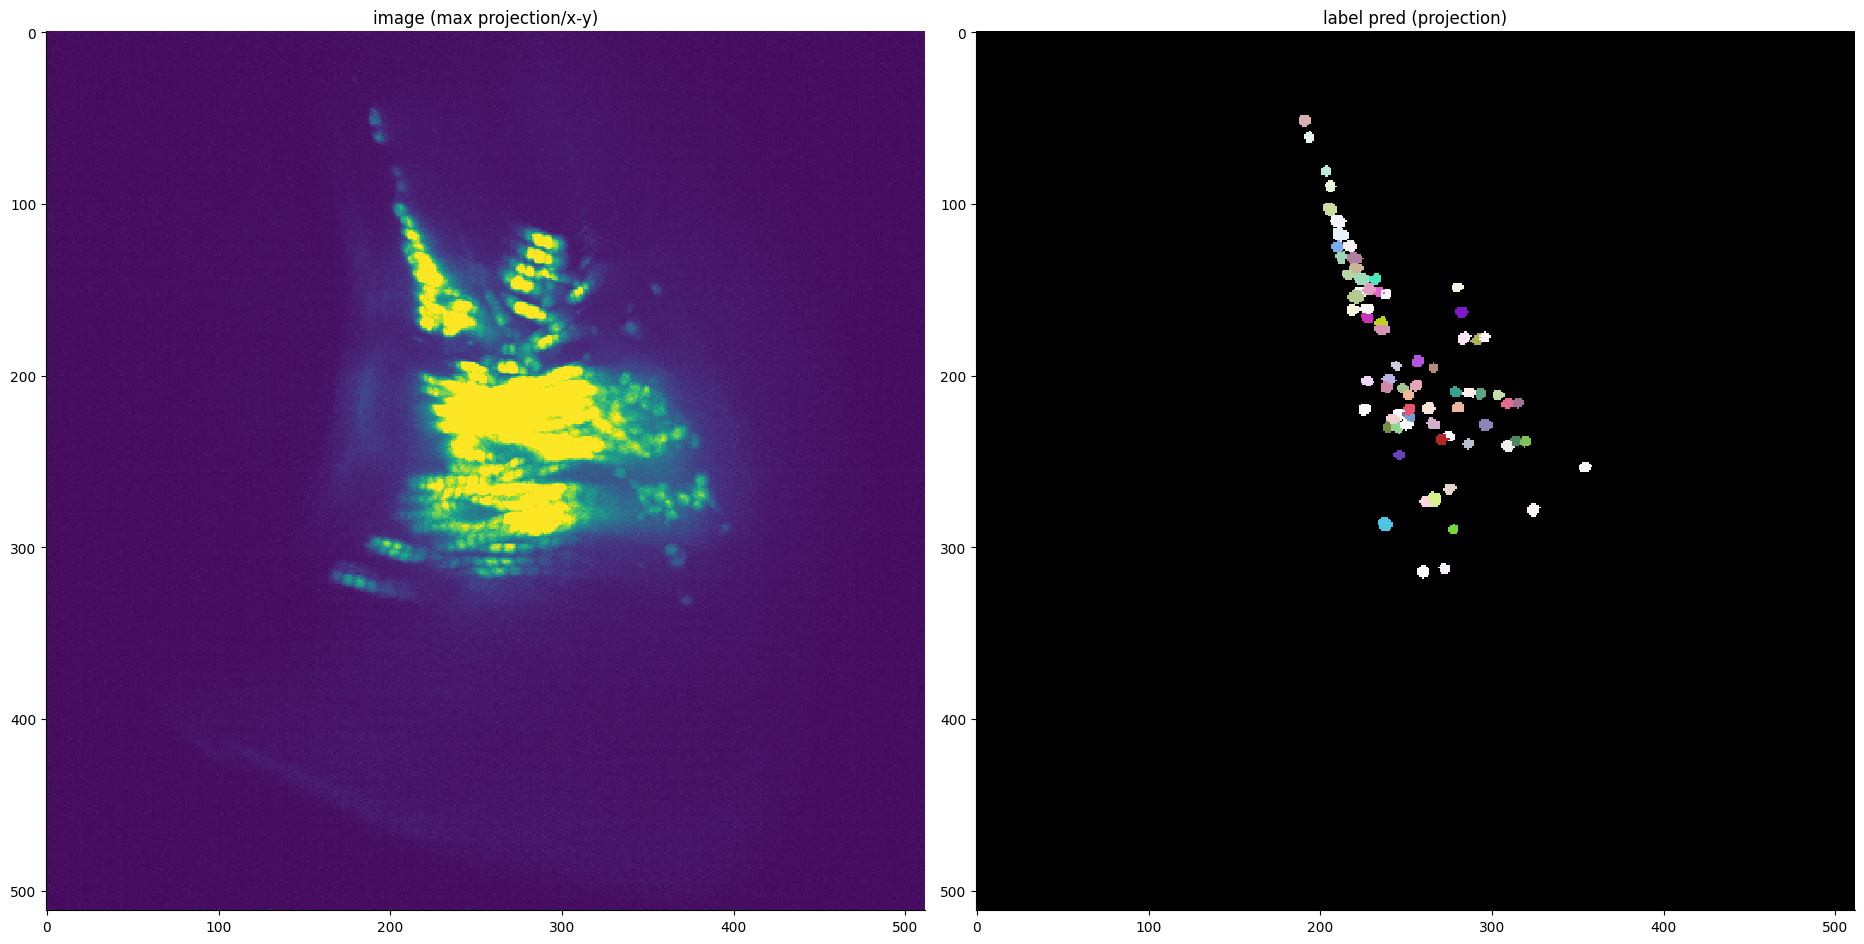

In [15]:
vol = 58

x = sdw.load_2d_slices_at_time(images_path=path_raw_images, t=vol)
print(f"Raw image shape at vol1: {x.shape}")

(labels, details), prob_map = model.predict_instances(x)
use_8_bit = True if labels.max() <= 255 else False

print(labels.shape)


output_folder = f"result_cell_detection"
output_path = os.path.join("E:/",output_folder)

if not os.path.exists(output_path):
    os.makedirs(output_path)

#for j in range(image.shape[1]):
    # 4次元データから2次元のデータを取得



    # TIFFファイルとして保存
file_name = f"labels_t={vol}.tif"
file_path = os.path.join(output_path, file_name)
#pil_image.save(file_path)
tiff.imsave(file_path, labels)

sdw.plot_img_label_max_projection(x, labels, lbl_title="label pred (projection)", fig_width_px=1800)

### Displaying max projections of raw images and predicted segmentation in x-z plane

### Parameters
- `scale_z`: A number (>0) specifying the scaling rate along the z-axis. This is useful when the resolution in the z-axis is significantly different from that in the x-axis.

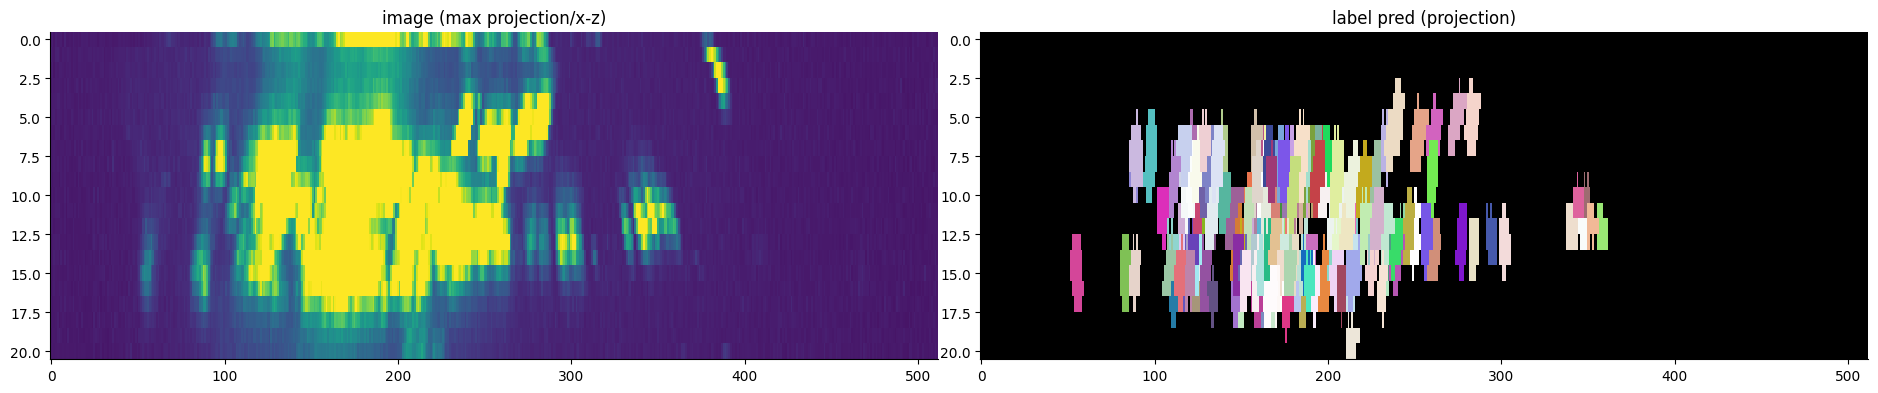

In [4]:
scale_z = 9

sdw.plot_img_label_max_projection_xz(x, labels, lbl_title="label pred (projection)", fig_width_px=1800, scale_z=scale_z)

### Segment all volumes 
The following code block segments cells in all volumes and saves the predicted cell coordinates and probability maps in the "seg" folder automatically.

In [20]:
sdw.predict_and_save(images_path=path_raw_images, model=model, results_folder=path_results)

#sdw.get_t_range(images_path=path_raw_images)

Segmenting images:   0%|  | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Segmenting images:   1%| | 1/120 [00:01<02:40,  1.

1/1 [==============================] - 0s 25ms/step


Segmenting images:   2%| | 2/120 [00:02<02:26,  1.

1/1 [==============================] - 0s 24ms/step


Segmenting images:   2%| | 3/120 [00:03<02:15,  1.

1/1 [==============================] - 0s 24ms/step


Segmenting images:   3%| | 4/120 [00:04<02:13,  1.

1/1 [==============================] - 0s 24ms/step


Segmenting images:   4%| | 5/120 [00:05<02:13,  1.

1/1 [==============================] - 0s 23ms/step


Segmenting images:   5%| | 6/120 [00:07<02:12,  1.

1/1 [==============================] - 0s 23ms/step


Segmenting images:   6%| | 7/120 [00:08<02:10,  1.

1/1 [==============================] - 0s 26ms/step


Segmenting images:   7%| | 8/120 [00:09<02:11,  1.

1/1 [==============================] - 0s 25ms/step


Segmenting images:   8%| | 9/120 [00:10<02:10,  1.

1/1 [==============================] - 0s 27ms/step


Segmenting images:   8%| | 10/120 [00:11<02:07,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:   9%| | 11/120 [00:12<02:08,  1

1/1 [==============================] - 0s 26ms/step


Segmenting images:  10%| | 12/120 [00:14<02:08,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  11%| | 13/120 [00:15<02:06,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  12%| | 14/120 [00:16<02:06,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  12%|▏| 15/120 [00:17<02:01,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  13%|▏| 16/120 [00:18<01:56,  1

1/1 [==============================] - 0s 26ms/step


Segmenting images:  14%|▏| 17/120 [00:19<01:59,  1

1/1 [==============================] - 0s 28ms/step


Segmenting images:  15%|▏| 18/120 [00:21<01:58,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  16%|▏| 19/120 [00:22<01:58,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  17%|▏| 20/120 [00:23<01:58,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  18%|▏| 21/120 [00:24<01:55,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  18%|▏| 22/120 [00:25<01:52,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  19%|▏| 23/120 [00:26<01:50,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  20%|▏| 24/120 [00:27<01:49,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  21%|▏| 25/120 [00:29<01:48,  1

1/1 [==============================] - 0s 27ms/step


Segmenting images:  22%|▏| 26/120 [00:30<01:50,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  22%|▏| 27/120 [00:31<01:55,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  23%|▏| 28/120 [00:32<01:51,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  24%|▏| 29/120 [00:34<01:48,  1

1/1 [==============================] - 0s 22ms/step


Segmenting images:  25%|▎| 30/120 [00:35<01:43,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  26%|▎| 31/120 [00:36<01:45,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  27%|▎| 32/120 [00:37<01:43,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  28%|▎| 33/120 [00:38<01:39,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  28%|▎| 34/120 [00:39<01:40,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  29%|▎| 35/120 [00:41<01:39,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  30%|▎| 36/120 [00:42<01:37,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  31%|▎| 37/120 [00:43<01:34,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  32%|▎| 38/120 [00:44<01:32,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  32%|▎| 39/120 [00:45<01:33,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  33%|▎| 40/120 [00:46<01:31,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  34%|▎| 41/120 [00:47<01:30,  1

1/1 [==============================] - 0s 26ms/step


Segmenting images:  35%|▎| 42/120 [00:49<01:31,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  36%|▎| 43/120 [00:50<01:31,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  37%|▎| 44/120 [00:51<01:26,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  38%|▍| 45/120 [00:52<01:23,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  38%|▍| 46/120 [00:53<01:24,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  39%|▍| 47/120 [00:54<01:21,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  40%|▍| 48/120 [00:55<01:20,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  41%|▍| 49/120 [00:57<01:27,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  42%|▍| 50/120 [00:58<01:24,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  42%|▍| 51/120 [00:59<01:21,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  43%|▍| 52/120 [01:00<01:17,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  44%|▍| 53/120 [01:01<01:16,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  45%|▍| 54/120 [01:02<01:14,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  46%|▍| 55/120 [01:03<01:12,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  47%|▍| 56/120 [01:05<01:12,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  48%|▍| 57/120 [01:06<01:11,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  48%|▍| 58/120 [01:07<01:06,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  49%|▍| 59/120 [01:08<01:04,  1

1/1 [==============================] - 0s 26ms/step


Segmenting images:  50%|▌| 60/120 [01:09<01:05,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  51%|▌| 61/120 [01:10<01:05,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  52%|▌| 62/120 [01:11<01:05,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  52%|▌| 63/120 [01:12<01:03,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  53%|▌| 64/120 [01:13<01:02,  1

1/1 [==============================] - 0s 22ms/step


Segmenting images:  54%|▌| 65/120 [01:15<01:02,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  55%|▌| 66/120 [01:16<01:00,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  56%|▌| 67/120 [01:17<00:59,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  57%|▌| 68/120 [01:18<00:58,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  57%|▌| 69/120 [01:19<00:57,  1

1/1 [==============================] - 0s 22ms/step


Segmenting images:  58%|▌| 70/120 [01:20<00:58,  1

1/1 [==============================] - 0s 22ms/step


Segmenting images:  59%|▌| 71/120 [01:22<00:58,  1

1/1 [==============================] - 0s 21ms/step


Segmenting images:  60%|▌| 72/120 [01:23<00:56,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  61%|▌| 73/120 [01:24<00:53,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  62%|▌| 74/120 [01:25<00:52,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  62%|▋| 75/120 [01:26<00:51,  1

1/1 [==============================] - 0s 22ms/step


Segmenting images:  63%|▋| 76/120 [01:27<00:50,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  64%|▋| 77/120 [01:28<00:50,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  65%|▋| 78/120 [01:30<00:49,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  66%|▋| 79/120 [01:31<00:47,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  67%|▋| 80/120 [01:32<00:46,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  68%|▋| 81/120 [01:33<00:44,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  68%|▋| 82/120 [01:34<00:43,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  69%|▋| 83/120 [01:35<00:42,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  70%|▋| 84/120 [01:36<00:40,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  71%|▋| 85/120 [01:38<00:40,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  72%|▋| 86/120 [01:39<00:38,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  72%|▋| 87/120 [01:40<00:37,  1

1/1 [==============================] - 0s 27ms/step


Segmenting images:  73%|▋| 88/120 [01:41<00:36,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  74%|▋| 89/120 [01:42<00:35,  1

1/1 [==============================] - 0s 25ms/step


Segmenting images:  75%|▊| 90/120 [01:43<00:33,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  76%|▊| 91/120 [01:44<00:31,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  77%|▊| 92/120 [01:45<00:31,  1

1/1 [==============================] - 0s 27ms/step


Segmenting images:  78%|▊| 93/120 [01:46<00:30,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  78%|▊| 94/120 [01:48<00:29,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  79%|▊| 95/120 [01:49<00:28,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  80%|▊| 96/120 [01:50<00:27,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  81%|▊| 97/120 [01:51<00:26,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  82%|▊| 98/120 [01:52<00:25,  1

1/1 [==============================] - 0s 24ms/step


Segmenting images:  82%|▊| 99/120 [01:54<00:24,  1

1/1 [==============================] - 0s 23ms/step


Segmenting images:  83%|▊| 100/120 [01:55<00:23,  

All images from t=1 to t=120 have been Segmented


## C. Manual correction

### Perform manual correction
- Manually correct the segmentation results saved in the "auto_vol1" folder, use software like ITK-SNAP. 
- Save the corrected segmentation as 2D slices in the TIFF format in the "manual_vol1" folder.

### Load the manually corrected segmentation

### Parameters
- `voxel_size`: A tuple of 3 numbers, indicating the size (in arbitrary units) of a voxel in the x, y, and z directions.
- `manual_seg_path`: A string specifying the file path to the manually corrected segmentation images.

Loaded the proofed segmentations at vol 1 with 168 cells


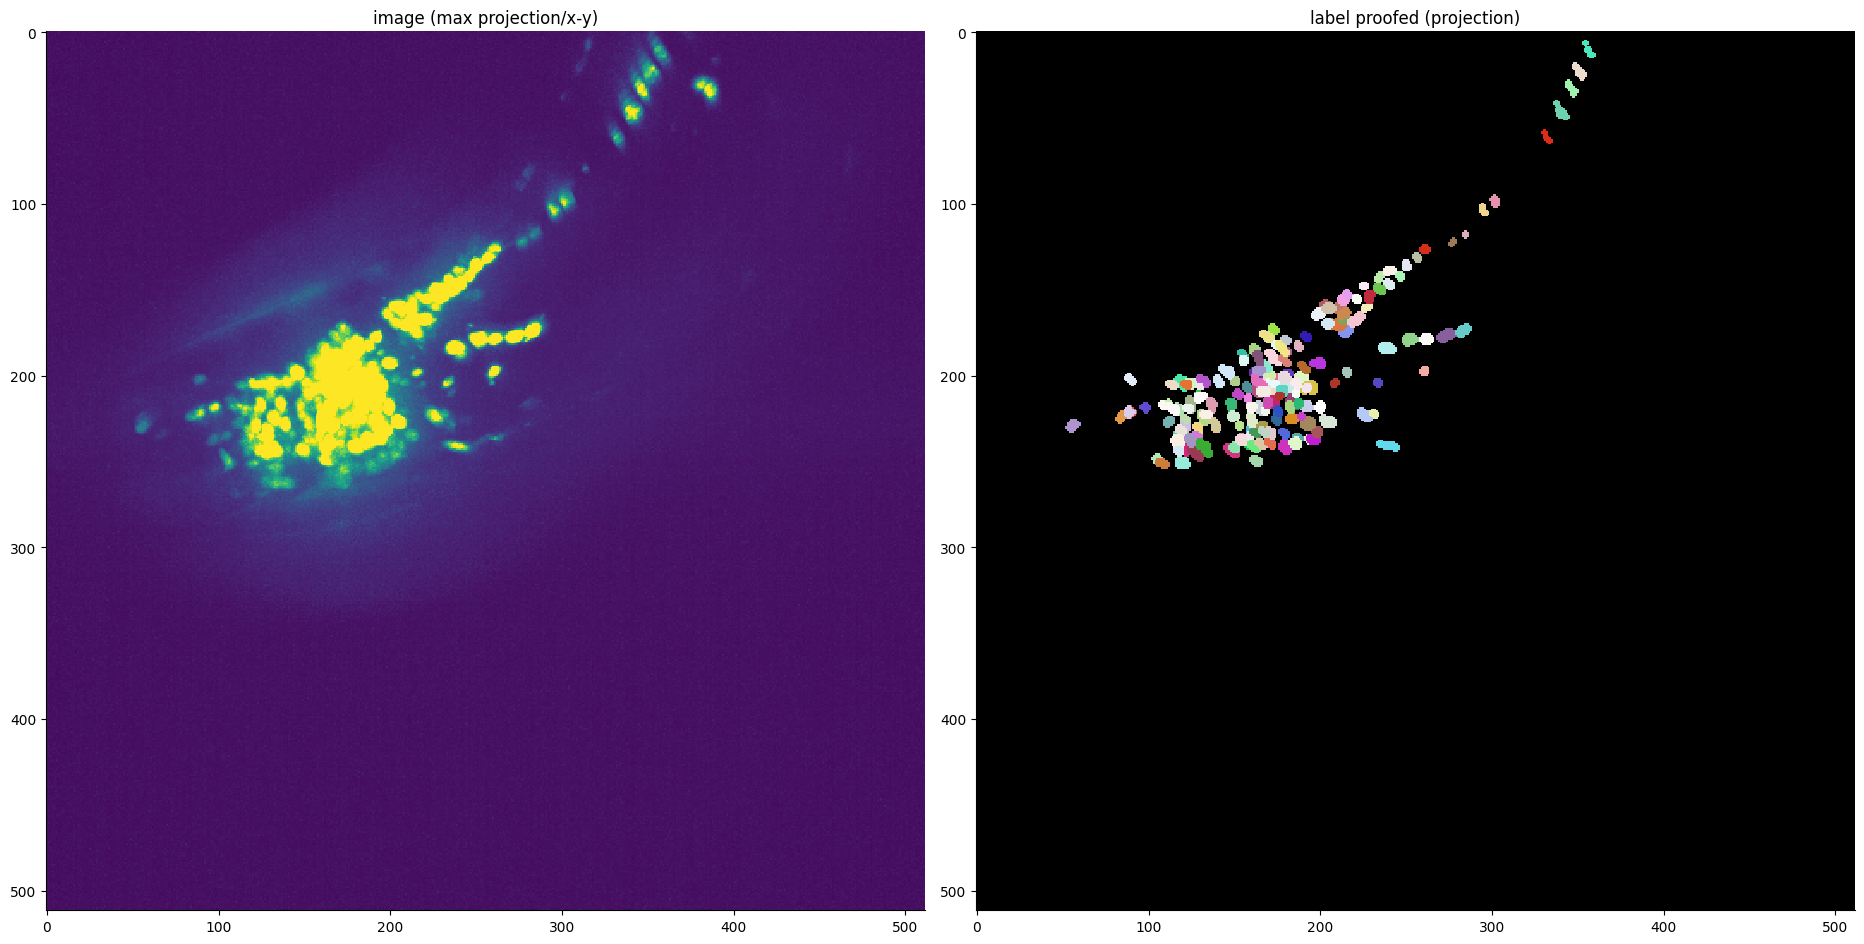

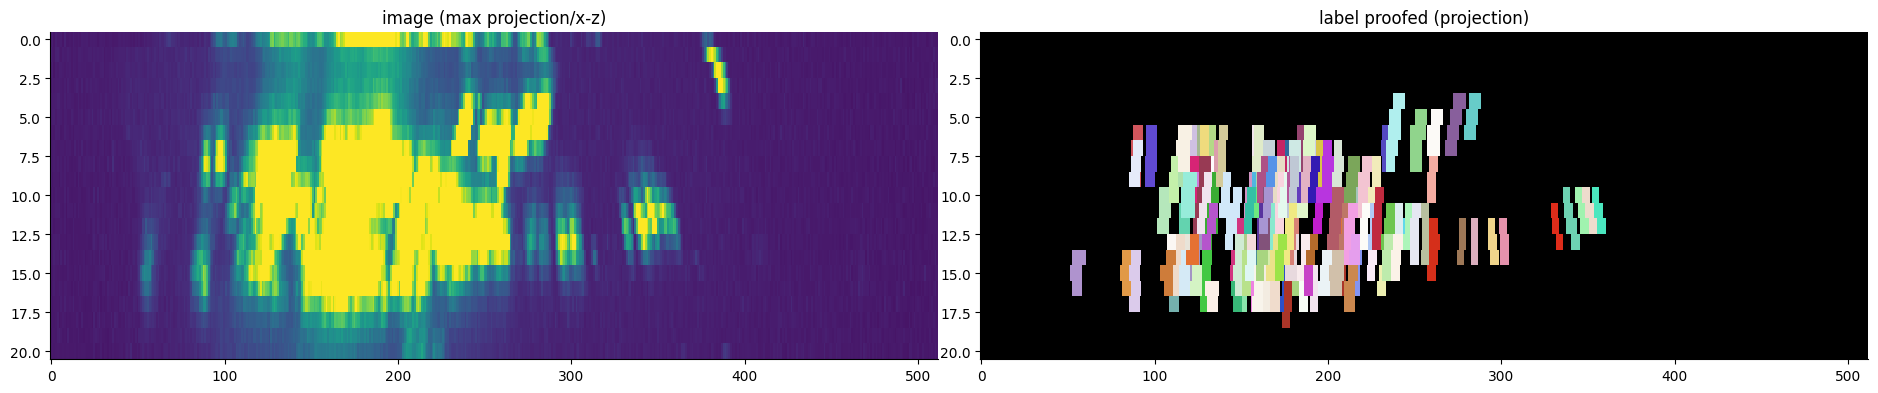

In [5]:
voxel_size=(5, 1, 1)
manual_seg_path="D:/c.elegans/3DeeCellTracker_result/C20230510_cam2_001_ch1/manual_vol1/*.tif"

coords2image = cit.CoordsToImageTransformer(results_folder=path_results, voxel_size=voxel_size)
coords2image.load_segmentation(manual_vol1_path=manual_seg_path)
sdw.plot_img_label_max_projection(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800)
sdw.plot_img_label_max_projection_xz(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800, scale_z=scale_z)

### Perform interpolation along z axis

### Parameters
- `interpolation_factor`: An integer parameter (>= 1) that specifies the factor by which the number of z-slices in the original 3D image should be increased. For example, if the original image has 10 z-slices and factor is set to 2, then the new image will have 20 z-slices.

### Notes
> The interpolated results are used to refine the positions of the tracking results. Increasing the number of z-slices via interpolation can improve the accuracy of the estimated cell positions. 

> The program employs a Gaussian blur filter to generate the interpolation. Even if the `interpolation_factor` is set to 1, the program still applies the filter without increasing the number of slices.

Interpolating images along z-axis...
The interpolated segmentations at vol 1 contains 170 cells
Calculating coordinates of cell centers...


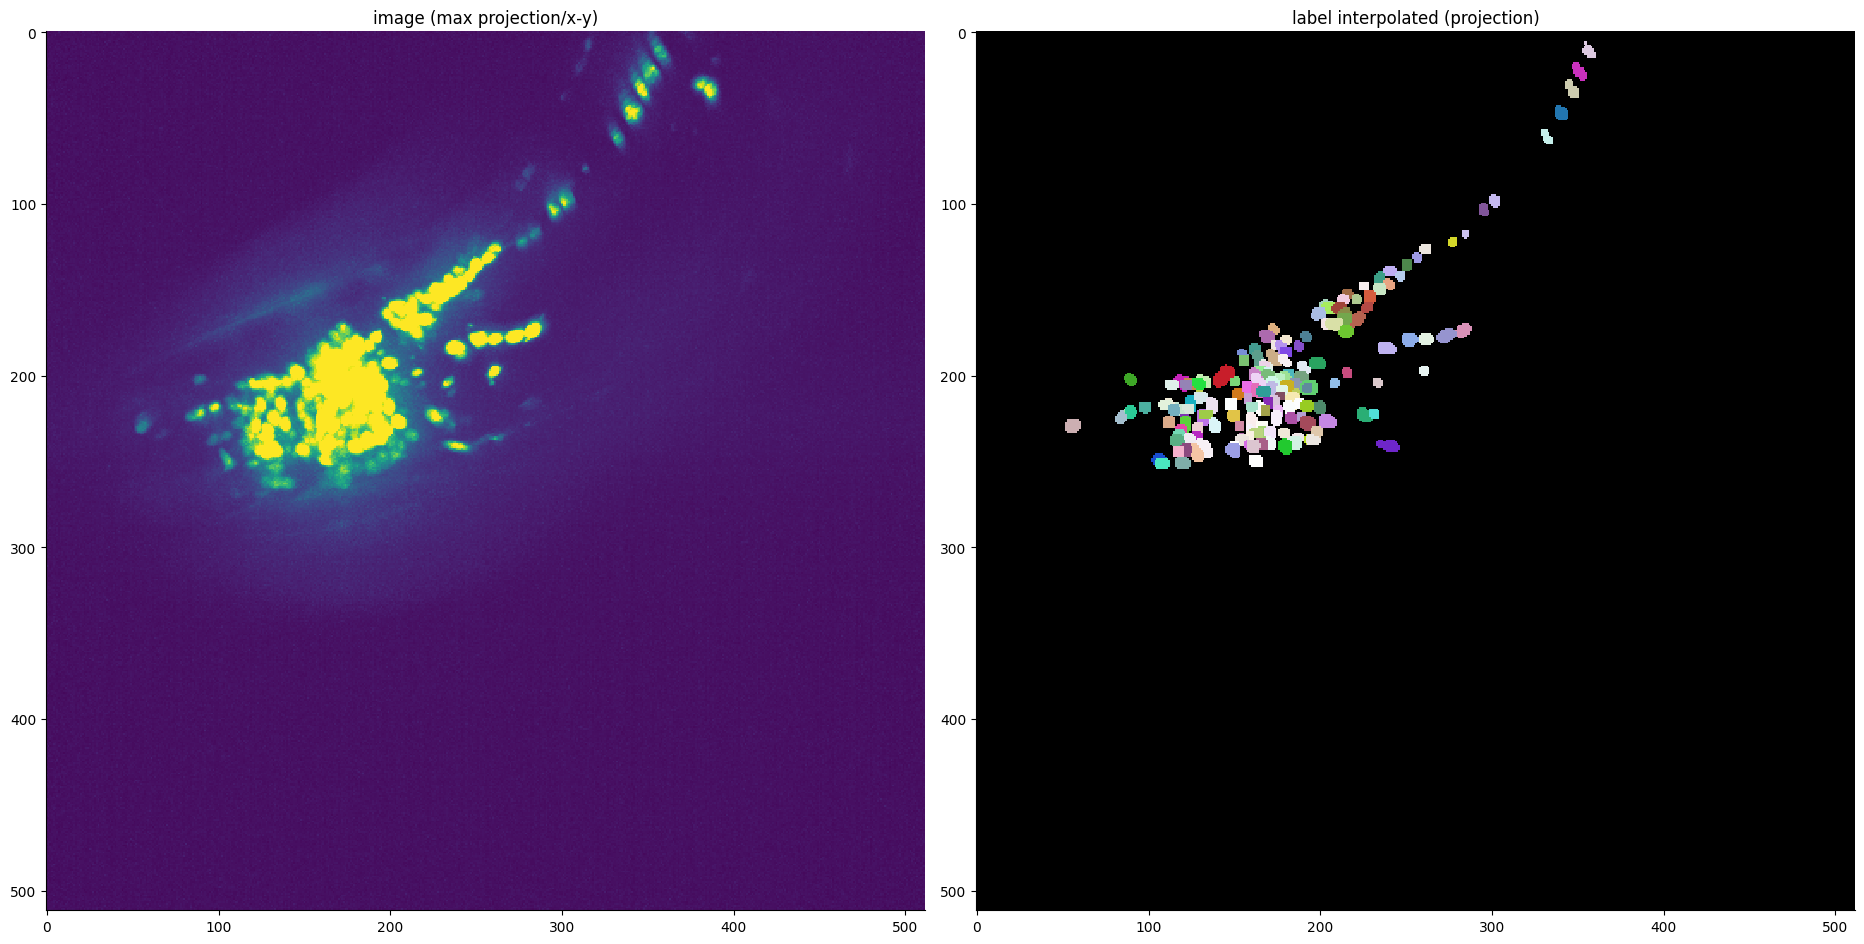

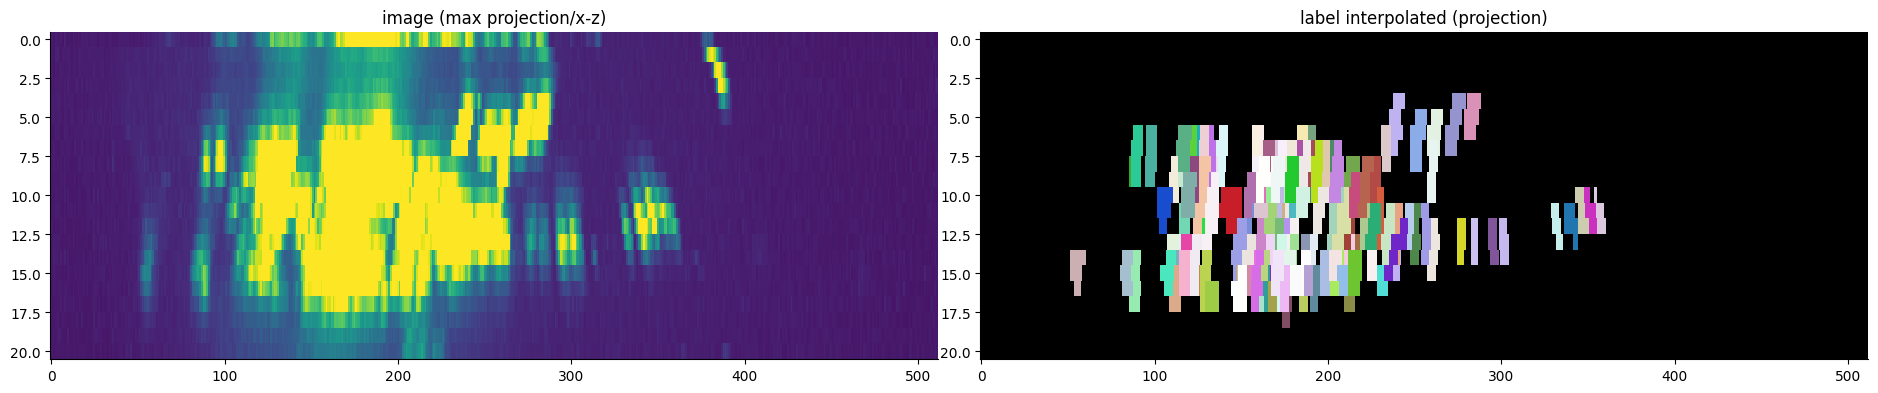

In [6]:
interpolation_factor = 10

coords2image.interpolate(interpolation_factor=interpolation_factor)
sdw.plot_img_label_max_projection(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800)
sdw.plot_img_label_max_projection_xz(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800,scale_z=scale_z)

## D. Tracking cells. 

### Initiate Tracker

### Parameters
- `ffn_model_name`: A string specifying the name of the ffn model to reload.

### Notes:
> By default, the function looks for the model with the specified name from the "ffn_models" directory. However, if you have saved the model in a different location, you can specify the `basedir` parameter to load the model from that directory.
```
    tracker = trl.TrackerLite(results_dir=path_results, ffn_model_name=ffn_model_name, proofed_coords_vol1=coords2image.coord_vol1, basedir=".\FolderA\FolderB\")
```    

In [7]:
ffn_model_name="ffn_worm4"

tracker = trl.TrackerLite(results_dir=path_results, ffn_model_name=ffn_model_name, proofed_coords_vol1=coords2image.coord_vol1)

### Test FFN matching

### Parameters
- `t1`: An integer specifying the volume number of the first segmentation
- `t2`: An integer specifying the volume number of the second segmentation

### Notes:
>  The program will match the segmented cell centers points (saved in the "seg" folder) between volumes t1 and t2.

9/9 [==============================] - 0s 3ms/step


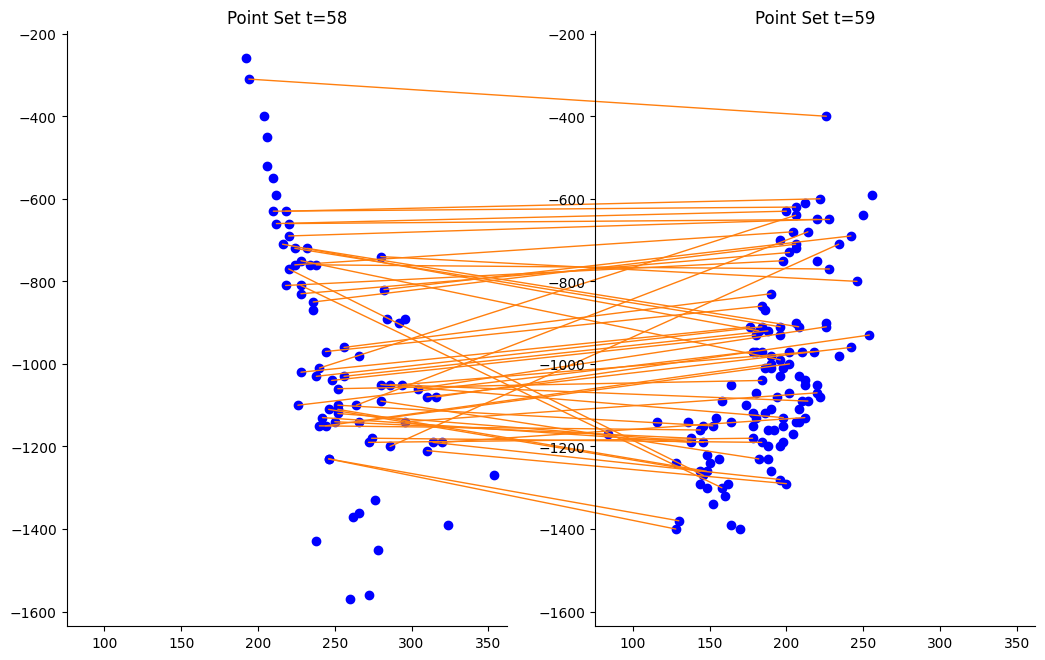

In [8]:
t1 = 58
t2 = 59

tracker.match_by_ffn(t1=t1, t2=t2)

### Test FFN + PR-GLS tracking

### Parameters
- `beta`: A numeric value (integer or float). A larger value will result in a larger window for estimating cell movement based on neighboring cells.
- `lambda_`: A numeric value (integer or float). A larger value will result in more similar movements across different cells.

### Notes:
> The program will estimate the new positions at time point `t2` for all cells segmented at time point `t1`. The FFN matching will be improved by PR-GLS to generate a more coherent estimation of cell movements.

> The default values of `beta` and `lambda_` are (3, 3), which are suitable for most cases. However, users can try different values to further improve the tracking.

9/9 [==============================] - 0s 3ms/step


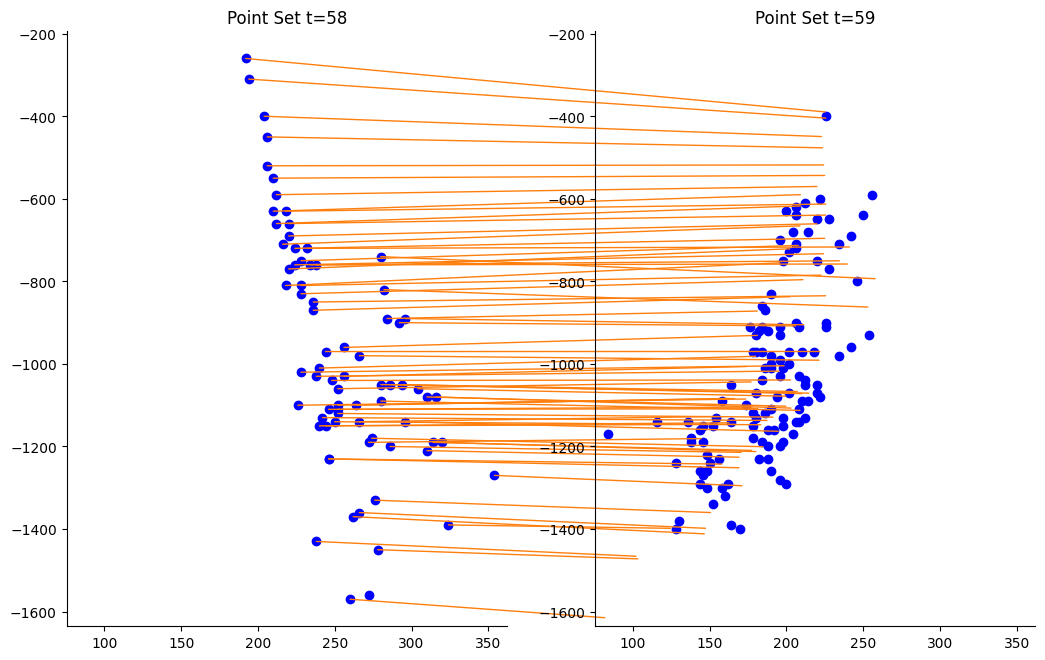

In [9]:
beta = 3
lambda_= 3

tracked_positions_t2 = tracker.predict_cell_positions(t1=t1, t2=t2, beta=beta, lambda_=lambda_, draw_fig=True)

### Track cells in following volumes in single mode

### Parameters
- `t_start`: An integer specifying the volume number of the first raw image. Usually, this value is set to 1, so that the program will load coordinates in volume 2, 3, 4, and so on for tracking. If `t_start` is not 1, then the subsequent volume numbers will be `t_start + 1`, `t_start + 2`, and so on.
- `t_end`: An integer specifying the volume number of the last raw image that should be tracked.
- `skipped_volumes`: A list of integers specifying the volumes that should be skipped during tracking. An empty list [] means no volume will be skipped.

### Notes:
> All tracking results will be automatically saved in the "track_results" folder, including:
> 1. The coordinates of tracked cells (in the same units as the `voxel_size`) - Folder "coords_real"
> 2. Figures showing the tracking in each volume - Folder "figure"
> 3. Images of the tracked labels in each volume - Folder "labels"
> 4. Merged images of the raw image and the tracked labels in each volume, projected on the x-y plane - Folder "merged_labels"
> 5. Merged images of the raw image and the tracked labels in each volume, projected on the x-z plane - Folder "merged_labels_xz"

In [27]:
t_start = 1
t_end =100
skipped_volumes = []

ensemble = False
t1 = t_start
confirmed_coord = coords2image.coord_vol1
grid = model.config.grid
for t in range(t_start+1, t_end+1):
    print(f"t={t}...", end="\r")
    if t in skipped_volumes:
        print(f"skip t={t}")
        continue
    coord_prgls = tracker.predict_cell_positions(t1=t1, t2=t, confirmed_coord_t1=confirmed_coord, beta=beta, lambda_=lambda_, draw_fig=False)
    confirmed_coord, corrected_labels_image = coords2image.accurate_correction(t, grid, coord_prgls, ensemble=ensemble)
    coords2image.save_tracking_results(confirmed_coord, corrected_labels_image, tracker, t1=t1, t2=t, images_path=path_raw_images)
    t1 = t

25/25 [==============================] - 0s 3ms/step


## E. Extract activities from tracked cells

### Extract activities

### Parameters
- `raw_path`: A string specifying the file path to the raw image to extract the activities. The image data should be in TIFF format.

### Notes
> This Code Block extracts activities from 3D time-lapse images, based on tracking results.

In [ ]:
raw_path = "./worm1/data/*t%03d*.tif"

activities = tracker.activities(raw_path=raw_path)

### Draw a figure to show the activities

In [ ]:
draw_signals(activities, ylim_lower=0, ylim_upper=2, figsize=(20, 10))

### Export the activities as csv file

### Parameters
- `csv_filename`: The filename of the csv file to save the extracted activities

In [ ]:
csv_filename = "activities_txcell.csv"

csv_filename = os.path.join(path_results, csv_filename)
timings = np.arange(1, activities.shape[0]+1).reshape(-1, 1)
activities_with_timings = np.concatenate((timings, activities), axis=1)
headers = ['timing'] + ['cell' + str(i) for i in range(1, activities.shape[1]+1)]
np.savetxt(csv_filename, activities_with_timings, delimiter=',', fmt='%.3f', header=','.join(headers), comments='')
print(f"The cell activities have been saved in {csv_filename}")